In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

The most recent date in the database is 2017-08-23
Last year date is 2016-08-23


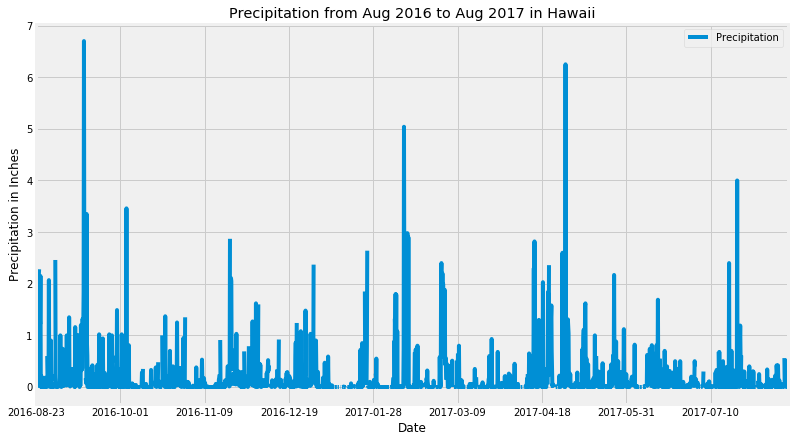

<Figure size 432x288 with 0 Axes>

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(f'The most recent date in the database is {latest_date[0]}')

# Calculate the date 1 year ago from the last data point in the database
past_year = dt.date(2017,8,23)- dt.timedelta(days=365)
print(f'Last year date is {past_year}')

# Perform a query to retrieve the data and precipitation scores
query = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= past_year).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
query_df = pd.DataFrame(query, columns = ['Date','Precipitation'])
#query_df.head()

#set the index to the date column
query_df.set_index('Date', inplace =True)

# Sort the dataframe by date
query_df=query_df.sort_values(by='Date', ascending=True)
query_df.head()

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_chart = query_df.plot (title = "Precipitation from Aug 2016 to Aug 2017 in Hawaii", figsize=(12,7))
plt.ylabel('Precipitation in Inches')
plt.show()
plt.tight_layout()
plt.savefig("Images/PrecipitationSinceLastYear.png")

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
query_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
# Design a query to show how many stations are available in this dataset?
station_query = session.query(Station.station).count()
print(f'There are {station_query} stations in the given dataset.')

There are 9 stations in the given dataset.


In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_station = session.query(Measurement.station, func.count(Measurement.station))\
                .group_by(Measurement.station)\
                .order_by (func.count(Measurement.station).desc())\
                .all()
print(f'The most active station is station {active_station[0][0]}.')
active_station

The most active station is station USC00519281.


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

station_active_info = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs))\
                      .filter(Measurement.station == 'USC00519281').all()
print(f'The temperatures recorded at the most active station are as given below:\n Lowest:{station_active_info[0][0]}, \n Highest:{station_active_info[0][1]}, \n Average:{station_active_info[0][2]}')

The temperatures recorded at the most active station are as given below:
 Lowest:54.0, 
 Highest:85.0, 
 Average:71.66378066378067


In [15]:
# Choose the station with the highest number of temperature observations.
highest_temp_obs = session.query(Measurement.station, func.count(Measurement.tobs))\
        .group_by(Measurement.station)\
        .order_by (func.count(Measurement.station).desc()).first()
highest_temp_obs[0]



'USC00519281'

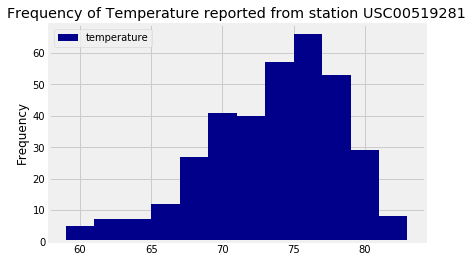

In [16]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_obs = session.query(Measurement.tobs).filter(Measurement.date >= past_year)\
            .filter(Measurement.station == 'USC00519281').all()
temp_obs = pd.DataFrame(temp_obs, columns=['temperature'])
temp_obs


#histogram

temp_obs.plot.hist(title='Frequency of Temperature reported from station USC00519281',color='darkblue', bins=12)
plt.tight_layout
plt.savefig("Images/TemperaturevsFrequency.png")
plt.show()

## Bonus Challenge Assignment

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
def calc_temps(start_date, end_date):

    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

print (calc_temps('2017-08-01','2017-08-07'))

trip_conditions = calc_temps('2017-08-01','2017-08-07')

[(72.0, 79.25, 83.0)]


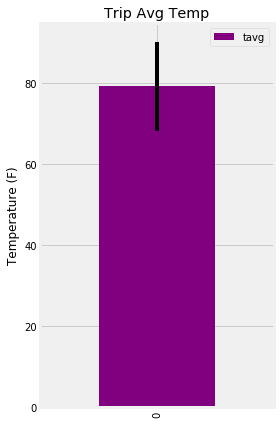

In [19]:
# Plot the results from your previous query as a bar chart. 
trip_conditions = pd.DataFrame(trip_conditions, columns=['tmin', 'tavg', 'tmax'])
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_conditions.plot.bar(y='tavg', yerr=(trip_conditions['tmax'] - trip_conditions['tmin']), title='Trip Avg Temp', color='purple', figsize=(4,6))
plt.ylabel("Temperature (F)")
plt.tight_layout()
plt.savefig("Images/TripAvgTemp.png")
plt.show()

In [20]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

#total_rainfall = session.query(Measurement.prcp, func.sum(Measurement.prcp)).filter(Measurement.date >= '2017-08-01').filter(Measurement.date <= '2017-08-07').all()
#print(f'The total rainfall from 1st August to 7th August last year was {total_rainfall[0][1]}')

def rainfall(start_date, end_date):
    data = [Measurement.station, Measurement.prcp, Station.name, Station.latitude, Station.longitude, Station.elevation]
    
    return session.query(*data)\
            .filter(Measurement.station == Station.station)\
            .filter(Measurement.date >= start_date)\
            .filter(Measurement.date <= end_date)\
            .group_by(Measurement.station)\
            .order_by(Measurement.prcp.desc())\
            .all()

data = pd.DataFrame(rainfall('2017-08-01','2017-08-07')).set_index('station')
data



,prcp,name,latitude,longitude,elevation
station,,,,,
USC00514830,0.12,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
USC00519397,0.02,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
USC00519523,0.00,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
USC00519281,0.00,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
USC00516128,NaN,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


In [21]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [22]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates
trip_dates = pd.date_range(start_date,end_date,freq = 'D')
trip_dates

#Stip off the year and save a list of %m-%d strings
trip_date_md = trip_dates.strftime("%m-%d")
trip_date_md

# Loop through the list of %m-%d strings and calculate the normals for each date
dates = []
for x in trip_date_md:
    dates.append(*daily_normals(x))
    
print(dates)

[(67.0, 75.54, 83.0), (68.0, 75.60377358490567, 84.0), (70.0, 76.61111111111111, 85.0), (69.0, 76.71153846153847, 84.0), (69.0, 76.14814814814815, 82.0), (67.0, 76.25, 83.0), (71.0, 77.15686274509804, 83.0)]


In [23]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df = pd.DataFrame(dates, columns=["Minimum", "Average", "Maximum"])
df['TripDates']=trip_date_md


#set TripDates as index column
df1= df.set_index(['TripDates'])
df1

,Minimum,Average,Maximum
TripDates,,,
08-01,67.0,75.540000,83.0
08-02,68.0,75.603774,84.0
08-03,70.0,76.611111,85.0
08-04,69.0,76.711538,84.0
08-05,69.0,76.148148,82.0
08-06,67.0,76.250000,83.0
08-07,71.0,77.156863,83.0


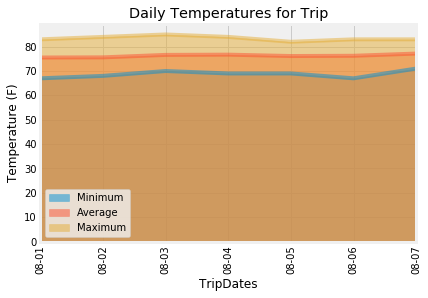

<Figure size 432x288 with 0 Axes>

In [24]:
# Plot the daily normals as an area plot with `stacked=False`
area_chart = df1.plot(kind='area', title = "Daily Temperatures for Trip",stacked=False, rot=90)
area_chart.set_ylabel("Temperature (F)")
plt.show()
#plt.tight_layout()
plt.savefig("Images/DailyTemperatures.jpg")